# Chapter 3: Reservoir Deliverability (IPR)
**Objective:** Construct Inflow Performance Relationship (IPR) curves for vertical wells using standard empirical correlations.
**Author:** Ade Anggi Naluriawan Santoso

The IPR curve represents the ability of the reservoir to deliver fluid to the wellbore. It plots the Flowing Bottomhole Pressure ($P_{wf}$) against the Production Rate ($q$).

In this notebook, we will implement:
1. **Vogel's Equation:** For solution-gas drive reservoirs (typically $P < P_b$).
2. **Fetkovich's Equation:** The empirical back-pressure method.
3. **IPR Plotting:** Visualizing the well's potential.

### The Scenario: Well Y
We have test data for **Well Y**:
* **Reservoir Pressure ($\bar{P}_r$):** 3000 psia
* **Test Rate ($q_{test}$):** 500 stb/d
* **Test Flowing Pressure ($P_{wf\_test}$):** 2000 psia
* **Bubble Point Pressure ($P_b$):** 3000 psia (Saturated reservoir)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Vogel's Equation
**Vogel (1968)** developed a dimensionless reference curve for solution-gas drive reservoirs based on computer simulations. It is widely used when the reservoir pressure is below the bubble point.

$$\frac{q_o}{q_{o,max}} = 1 - 0.2 \left( \frac{P_{wf}}{\bar{P}_r} \right) - 0.8 \left( \frac{P_{wf}}{\bar{P}_r} \right)^2$$

Where:
* $q_{o,max}$ is the Absolute Open Flow (AOF) potential (rate when $P_{wf} = 0$).

In [2]:
def calc_q_vogel(p_wf, p_res, q_max):
    """
    Calculates flow rate at a specific P_wf using Vogel's equation.
    """
    # Safety check: if P_wf > P_res, flow is zero (or negative, implying injection)
    if p_wf > p_res:
        return 0.0
    
    # Dimensionless Pressure
    p_ratio = p_wf / p_res
    
    # Vogel's calculation
    q = q_max * (1 - 0.2 * p_ratio - 0.8 * (p_ratio ** 2))
    return q

def calc_qmax_vogel(q_test, p_wf_test, p_res):
    """
    Calculates AOF (q_max) given a single test point.
    """
    p_ratio = p_wf_test / p_res
    q_max = q_test / (1 - 0.2 * p_ratio - 0.8 * (p_ratio ** 2))
    return q_max

## 2. Fetkovich's Equation
**Fetkovich (1973)** proposed an empirical back-pressure equation, often used for gas wells but also applicable to oil wells.

$$q_o = C (\bar{P}_r^2 - P_{wf}^2)^n$$

Where:
* $C$ is the productivity coefficient.
* $n$ is the flow exponent (ranges from 0.5 to 1.0).

In [3]:
def calc_q_fetkovich(p_wf, p_res, C, n):
    """
    Calculates flow rate using Fetkovich's equation.
    """
    if p_wf > p_res:
        return 0.0
    
    q = C * ((p_res**2) - (p_wf**2)) ** n
    return q

def fit_fetkovich(p_res, test_points):
    """
    Fits C and n parameters given a list of test points.
    test_points = [(q1, pwf1), (q2, pwf2)]
    
    Uses linear regression on log-log form:
    log(q) = log(C) + n * log(Pres^2 - Pwf^2)
    """
    qs = np.array([pt[0] for pt in test_points])
    pwfs = np.array([pt[1] for pt in test_points])
    
    # Delta P squared
    delta_p2 = (p_res**2) - (pwfs**2)
    
    # Log-Log transformation
    x = np.log(delta_p2)
    y = np.log(qs)
    
    # Linear Fit (y = mx + c) -> (log(q) = n * log(dP2) + log(C))
    n, log_C = np.polyfit(x, y, 1)
    C = np.exp(log_C)
    
    return C, n

## 3. Exercise: Constructing the IPR Curve
Let's use the test data from **Well Y** to construct the full IPR curve.

**Step 1:** Calculate $q_{max}$ (AOF) using Vogel's method and the single test point.

**Step 2:** Generate a range of $P_{wf}$ values from 0 to $P_{res}$.

**Step 3:** Calculate the corresponding rates ($q$).

Absolute Open Flow (AOF): 978.26 stb/d


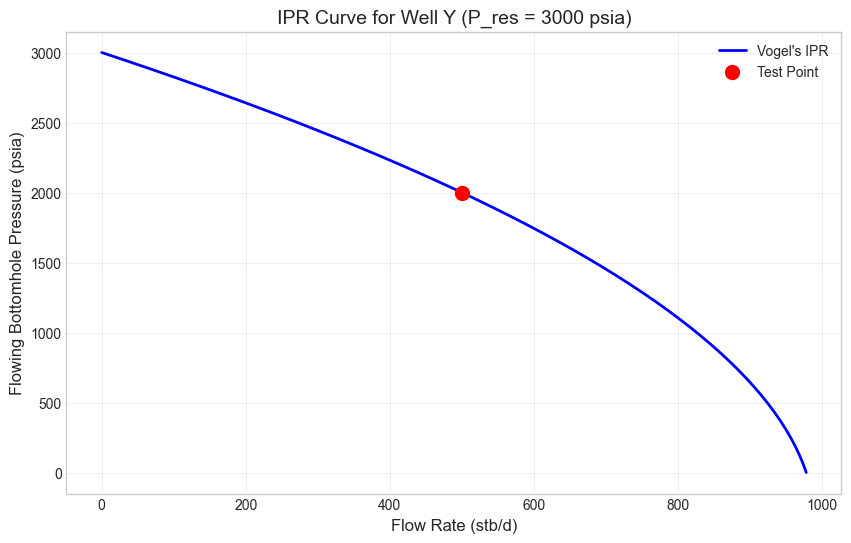

In [7]:
# --- INPUTS ---
p_res = 3000      # psia
q_test = 500      # stb/d
pwf_test = 2000   # psia

# 1. Calculate AOF (q_max)
q_max = calc_qmax_vogel(q_test, pwf_test, p_res)
print(f"Absolute Open Flow (AOF): {q_max:.2f} stb/d")

# 2. Generate Pressure Steps (from 0 to Reservoir Pressure)
# We use 50 points to make a smooth curve
pressure_steps = np.linspace(0, p_res, 50)

# 3. Calculate Rates for each pressure step
# We use a list comprehension here
rates_vogel = [calc_q_vogel(p, p_res, q_max) for p in pressure_steps]

# --- PLOTTING ---
plt.figure(figsize=(10, 6))

# Plot the calculated curve
plt.plot(rates_vogel, pressure_steps, label="Vogel's IPR", color='blue', linewidth=2)

# Plot the original test point to verify fit
plt.scatter(q_test, pwf_test, color='red', s=100, label='Test Point', zorder=5)

plt.title(f"IPR Curve for Well Y (P_res = {p_res} psia)", fontsize=14)
plt.xlabel("Flow Rate (stb/d)", fontsize=12)
plt.ylabel("Flowing Bottomhole Pressure (psia)", fontsize=12)

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 4. Advanced: Composite IPR (Undersaturated Reservoirs)

When the reservoir pressure ($\bar{P}_r$) is **above** the bubble point pressure ($P_b$), the fluid remains single-phase (liquid only) as long as the pressure stays above $P_b$. Once the pressure drops below $P_b$ near the wellbore, gas breaks out, and the flow becomes two-phase.

This requires a **Composite IPR** combining two distinct behaviors:

**1. Region 1: $P_{wf} \ge P_b$ (Single Phase Flow)**
The flow behaves linearly according to Darcy's Law. We use a constant Productivity Index ($J$).
$$q = J(\bar{P}_r - P_{wf})$$

**2. Region 2: $P_{wf} < P_b$ (Two-Phase Flow)**
The flow follows a Vogel-like curve, but anchored at the bubble point rate ($q_b$).
$$q = q_b + \frac{J P_b}{1.8} \left[ 1 - 0.2 \left( \frac{P_{wf}}{P_b} \right) - 0.8 \left( \frac{P_{wf}}{P_b} \right)^2 \right]$$

Where:
* $q_b$ is the flow rate exactly at the bubble point: $q_b = J(\bar{P}_r - P_b)$
* The factor **1.8** ensures the slope of the curve matches the straight line at the connection point ($P_b$).

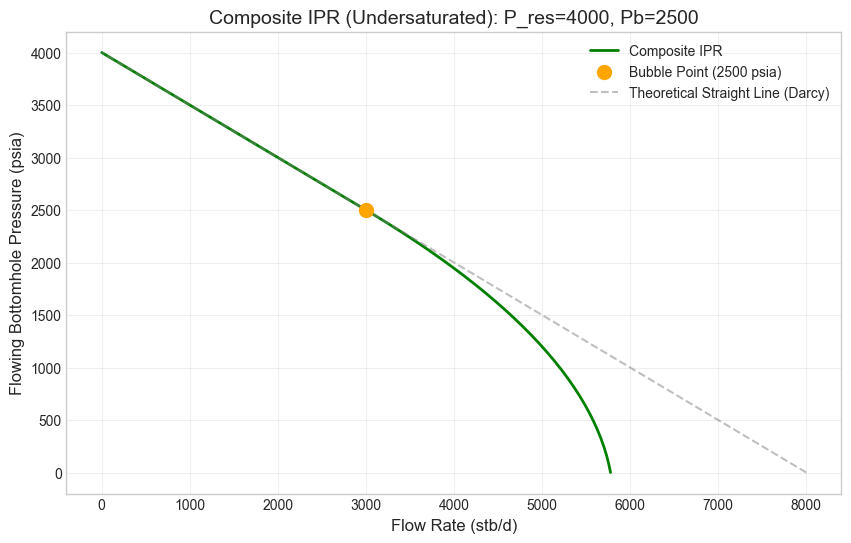

In [6]:
def calc_composite_ipr(p_wf, p_res, p_b, J):
    """
    Calculates flow rate for a Composite IPR (Undersaturated Reservoir).
    
    Parameters:
    p_wf  : Flowing bottomhole pressure (psia)
    p_res : Average reservoir pressure (psia)
    p_b   : Bubble point pressure (psia)
    J     : Productivity Index (stb/d/psi)
    """
    # Safety Check
    if p_wf > p_res:
        return 0.0
    
    # Calculate rate at the bubble point (q_b)
    # This is the max rate possible while staying in single-phase liquid flow
    q_b = J * (p_res - p_b)
    
    # CASE 1: Flowing pressure is ABOVE Bubble Point (Straight Line)
    if p_wf >= p_b:
        return J * (p_res - p_wf)
    
    # CASE 2: Flowing pressure is BELOW Bubble Point (Vogel Curve)
    else:
        # Calculate the incremental flow from the two-phase region
        # The term (J * p_b / 1.8) represents the q_max_increment
        p_ratio = p_wf / p_b
        q_vogel_part = (J * p_b / 1.8) * (1 - 0.2 * p_ratio - 0.8 * (p_ratio**2))
        
        return q_b + q_vogel_part

# --- EXERCISE: COMPOSITE IPR PLOT ---

# Inputs for an Undersaturated Well
p_res_under = 4000   # psia (High pressure)
p_bubble    = 2500   # psia (Saturation pressure)
J_index     = 2.0    # stb/d/psi (Productivity Index)

# 1. Generate Pressure Steps
pressure_steps = np.linspace(0, p_res_under, 50)

# 2. Calculate Rates
rates_composite = [calc_composite_ipr(p, p_res_under, p_bubble, J_index) for p in pressure_steps]

# 3. Plotting
plt.figure(figsize=(10, 6))

# Plot the composite curve
plt.plot(rates_composite, pressure_steps, label="Composite IPR", color='green', linewidth=2)

# Add a marker for the Bubble Point to visualize the transition
q_at_bubble = calc_composite_ipr(p_bubble, p_res_under, p_bubble, J_index)
plt.scatter(q_at_bubble, p_bubble, color='orange', s=100, label=f'Bubble Point ({p_bubble} psia)', zorder=5)


# Add Reference Line (if it were straight Darcy flow all the way)
# This helps visualize the "loss" of production due to gas breakout
darcy_rates = [J_index * (p_res_under - p) for p in pressure_steps]
plt.plot(darcy_rates, pressure_steps, label="Theoretical Straight Line (Darcy)", color='gray', linestyle='--', alpha=0.5)

plt.title(f"Composite IPR (Undersaturated): P_res={p_res_under}, Pb={p_bubble}", fontsize=14)
plt.xlabel("Flow Rate (stb/d)", fontsize=12)
plt.ylabel("Flowing Bottomhole Pressure (psia)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()